# Explaining Object classification using SHAP

In this notebook, we will segment objects in an image and classify them using shape measurements. Using [SHAP Analysis](https://shap.readthedocs.io/en/latest/) we can explain what role the different shape descriptors play.

In [1]:
import numpy as np
from skimage.io import imread
from skimage.measure import label, regionprops_table
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
import stackview

We use the blobs example image which contains multiple objects which could be grouped according to their size and shape. For example the 8-shaped objects in the center could be identified as group.

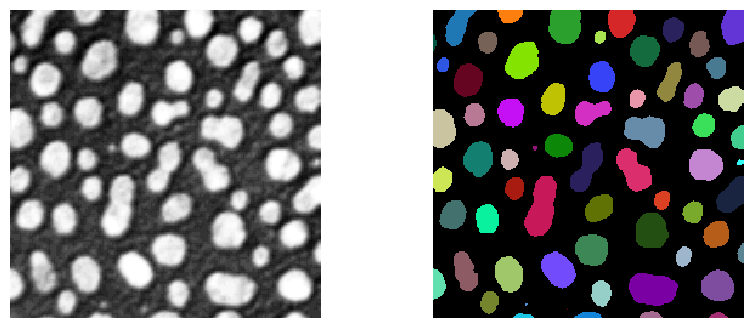

In [2]:
# Load the image
image = imread('data/blobs.tif')
# Apply threshold and 
binary = image > 120
# Label connected components
labels = label(binary)

import stackview
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
stackview.imshow(image, plot=ax[0])
stackview.imshow(labels, plot=ax[1]) 

## Extract region properties
To allow object classification using shape features, we need to measure and compute the features.

In [3]:
# Measure object properties using scikit-image
properties = ['label', 'area', 'perimeter', 'mean_intensity', 'max_intensity', 
             'min_intensity', 'eccentricity', 'solidity', 'extent', "minor_axis_length", "major_axis_length"]
measurements = regionprops_table(labels, intensity_image=image, properties=properties)
df = pd.DataFrame(measurements)
# Add aspect ratio column
df['aspect_ratio'] = df['major_axis_length'] / df['minor_axis_length']

display(df.head())

,label,area,perimeter,mean_intensity,max_intensity,min_intensity,eccentricity,solidity,extent,minor_axis_length,major_axis_length,aspect_ratio
0,1,433.0,91.254834,190.854503,232.0,128.0,0.876649,0.881874,0.555128,16.819060,34.957399,2.078439
1,2,185.0,53.556349,179.286486,224.0,128.0,0.828189,0.968586,0.800866,11.803854,21.061417,1.784283
2,3,658.0,95.698485,205.617021,248.0,128.0,0.352060,0.977712,0.870370,28.278264,30.212552,1.068402
3,4,434.0,76.870058,217.327189,248.0,128.0,0.341084,0.973094,0.820416,23.064079,24.535398,1.063793
4,5,477.0,83.798990,212.142558,248.0,128.0,0.771328,0.977459,0.865699,19.833058,31.162612,1.571246


## Annotation data
Next we load some annotation data. The annotation was hand-drawn on a label image and needs to be converted to tabular format first.

In [4]:
# Load annotation image and extract maximum intensity per label
annotation_image = imread('data/blobs_label_annotation.tif')
annotation_props = regionprops_table(labels, intensity_image=annotation_image, 
                                    properties=['label', 'max_intensity'])
annotation_df = pd.DataFrame(annotation_props)
annotation_df = annotation_df.rename(columns={'max_intensity': 'annotation'})

# Merge with main dataframe
df = df.merge(annotation_df, on='label')
display(df.head())

,label,area,perimeter,mean_intensity,max_intensity,min_intensity,eccentricity,solidity,extent,minor_axis_length,major_axis_length,aspect_ratio,annotation
0,1,433.0,91.254834,190.854503,232.0,128.0,0.876649,0.881874,0.555128,16.819060,34.957399,2.078439,0.0
1,2,185.0,53.556349,179.286486,224.0,128.0,0.828189,0.968586,0.800866,11.803854,21.061417,1.784283,0.0
2,3,658.0,95.698485,205.617021,248.0,128.0,0.352060,0.977712,0.870370,28.278264,30.212552,1.068402,2.0
3,4,434.0,76.870058,217.327189,248.0,128.0,0.341084,0.973094,0.820416,23.064079,24.535398,1.063793,0.0
4,5,477.0,83.798990,212.142558,248.0,128.0,0.771328,0.977459,0.865699,19.833058,31.162612,1.571246,0.0


In [5]:
len(df)

64

## Train Random Forest Classifier
Next, we train a random forest classifier. Therefore, we exctract only the objects which were annotated.

In [6]:
annotated_df = df[df['annotation'] != 0]
len(annotated_df)

12

In [7]:
# Prepare data for classification
feature_columns = ["solidity", "perimeter", "area", "aspect_ratio", "extent"]
                  # annotated_df.columns #['area', 'perimeter', 'mean_intensity', 'max_intensity', 
                  # 'min_intensity', 'eccentricity', 'solidity', 'extent']
X = annotated_df[feature_columns]
y = annotated_df['annotation']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Print accuracy
print(f"Training accuracy: {rf.score(X_train, y_train):.3f}")
print(f"Testing accuracy: {rf.score(X_test, y_test):.3f}")

Training accuracy: 1.000
Testing accuracy: 0.333


We can now apply this classifier to the entire dataset.

In [8]:
y_ = rf.predict(df[feature_columns])
y_

array([1., 3., 3., 3., 3., 3., 2., 3., 3., 1., 3., 3., 2., 3., 3., 1., 3.,
       3., 3., 3., 3., 3., 1., 3., 3., 3., 1., 3., 3., 3., 1., 2., 1., 3.,
       3., 1., 3., 1., 3., 3., 2., 3., 3., 3., 3., 3., 3., 3., 1., 3., 3.,
       1., 3., 3., 3., 1., 3., 3., 3., 2., 1., 3., 1., 1.])

[[0 0 0 ... 3 3 3]
 [0 0 0 ... 3 3 3]
 [0 0 0 ... 3 3 3]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
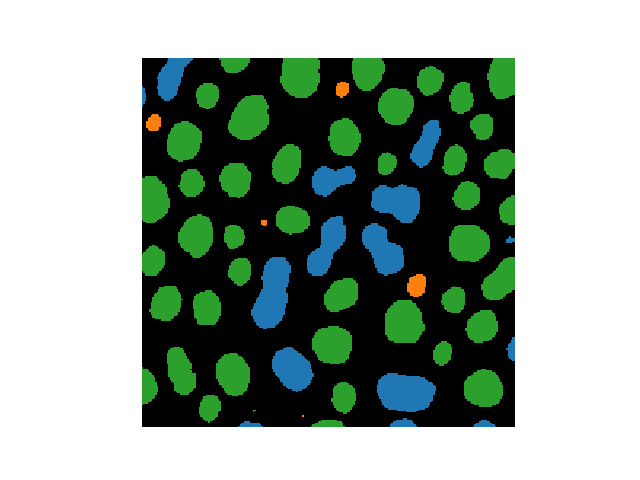

In [9]:
# Map labels to y values
result = labels.copy()
for i, label_id in enumerate(np.unique(labels)[1:], 1):  # skip 0 as it's background
    result[labels == label_id] = y_[i-1]

# Show result
stackview.insight(result)

## Explain classification using SHAP values
Using the SHAP-plot we can determine which features contribute most to the decision of the classifier. The plot below can be interpreted like this:
* The `solidity` and `extend` features contribute most to the classification. If solidity abd extend are low (blue), the object might be 8-shaped.
* Also `perimeter` and `aspect_ratio` contribute. If they are high, the object might be 8-shaped.
* The `area` contributes as well, just a little les prominently. If objects are large, they are more likely to be 8-shaped.

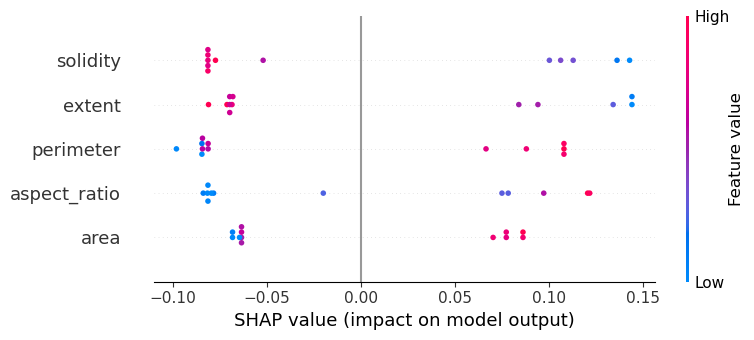

In [10]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)[...,0]

shap.summary_plot(shap_values, X) #, feature_names=feature_columns)

## Exercise
Draw the SHAP summary plot for the shap values `[..., 1]`. Which object class was this SHAP plot drawn for?